In [46]:
%matplotlib inline
import numpy as np
from scipy.spatial import distance_matrix
from scipy.spatial.distance import pdist


# We want to solve the Vehicle Routing Problem
# We first generate a random problem
k = 4
m = 3
n = 10

H = ['h_'+str(i) for i in range(k)]
M = ['m_'+str(i) for i in range(m)]
N = ['n_'+str(i) for i in range(n)]
Y = ['y_'+ v for v in M + N]

H_p = np.random.rand(k,2)
M_p = np.random.rand(m,2)
N_p = np.random.rand(n,2)

quantities = {f: 20 for f in N}
quantities_v = [quantities[f] for f in N]
capacities = {i:60 for i in range(k)}

In [47]:
# Generate a distance function
def get_entry(a,v):
    t=v
    if a == 'h':
        return H_p[int(v),:]
    if a == 'm':
        return M_p[int(v),:]
    if a == 'n':
        return N_p[int(v),:]

def v_distance(v1, v2):
    return(np.sqrt(np.sum((get_entry(*str.split(v1,'_'))-get_entry(*str.split(v2,'_')))**2)))


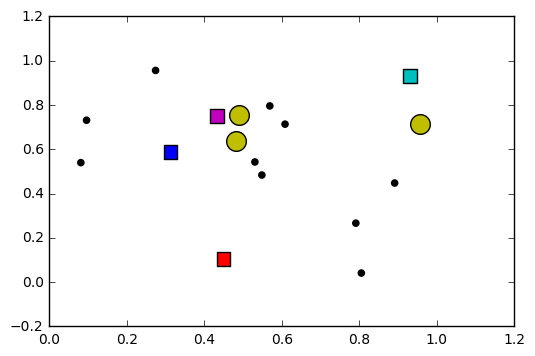

In [48]:
import matplotlib.pyplot as plt
# Draw points
# Mills are in yellow circles
# Houses of trucks are squares
# Dots are farmers
colors = ['r', 'b', 'c', 'm']

plt.scatter(N_p[:,0], N_p[:,1], c='k', s = quantities_v)
plt.scatter(M_p[:,0], M_p[:,1], c='y', marker = 'o', s = 200)
plt.scatter(H_p[:,0], H_p[:,1], c= colors[0:k], marker = 's', s = 100)
plt.show()

In [49]:
# Write model
import math
import random
from gurobipy import *

model = Model()

In [50]:
#Create variables for the model
vars = {}
# First key is truck
for truck in range(k):
    vars[truck] = {}
    # Going from house to farmer
    house = H[truck]
    vars[truck][house] = {}
    for farmer in N:
        vars[truck][house][farmer] = model.addVar(obj=v_distance(house, farmer), vtype=GRB.BINARY,
                          name='t_'+str(truck)+','+house+','+farmer)
    # Going from house to house
    vars[truck][house][house] = model.addVar(obj=0, vtype=GRB.BINARY,
                          name='t_'+str(truck)+','+house+','+house)
    # Going from farmer to farmer
    for f1 in N:
        vars[truck][f1] = {}
        for f2 in N:
            if (f1!=f2):
                vars[truck][f1][f2] = model.addVar(obj=v_distance(f1, f2), vtype=GRB.BINARY,
                          name='t_'+str(truck)+','+f1+','+f2)
                
    # Going from farmer to mill
    for farmer in N:
        for mill in M:
            vars[truck][farmer][mill] = model.addVar(obj=v_distance(farmer, mill), vtype=GRB.BINARY,
                        name='t_'+str(truck)+','+farmer+','+mill)
            
    # Going from mill to home
    for mill in M:
        vars[truck][mill] = {}
        vars[truck][mill][house] = model.addVar(obj=v_distance(mill, house), vtype=GRB.BINARY,
                        name='t_'+str(truck)+','+mill+','+house)
model.update()

In [51]:
# We add restriction (1) so all farmers are visited
for farmer in N:
    model.addConstr(quicksum(vars[truck][vertex][farmer] \
                         for truck in range(k) for vertex in (list(set(N)-set([farmer])) + [H[truck]]))==1)

In [52]:
# Add restriction (2) so all nodes are visited once
for truck in range(k):
    # This is for farmer nodes
    for farmer in N:
        s1 = quicksum(vars[truck][farmer][i] for i in vars[truck][farmer].keys())
        house = H[truck]
        s1 -= vars[truck][house][farmer]
        for f2 in N:
            if farmer!=f2:
                s1 -= vars[truck][f2][farmer]
        model.addConstr(s1 == 0)
    # This is for houses
    house = H[truck]
    s1 = quicksum(vars[truck][house][i] for i in vars[truck][house].keys())
    for m in M:
        s1 -= vars[truck][m][house]
    s1 -= vars[truck][house][house]
    model.addConstr(s1 == 0)
    # This is for mills
    for mill in M:
        s1 = quicksum(vars[truck][mill][i] for i in vars[truck][mill].keys())
        for farmer in N:
            s1 -= vars[truck][farmer][mill]
        model.addConstr(s1 == 0)

In [53]:
truck

3

In [54]:
# We add capacity constraints (3)
for truck in range(k):
    s1 = 0
    for farmer in N:
        s1 += quantities[farmer]*quicksum(vars[truck][farmer][i] for i in vars[truck][farmer].keys())
    model.addConstr(s1 <= capacities[truck])

In [55]:
# Trucks should leave their houses (4)
for truck in range(k):
    house = H[truck]
    model.addConstr(quicksum(vars[truck][house][i] for i in vars[truck][house].keys()) == 1)

In [56]:
# We finish with the cycle restrictions (5)
y_vars = {v:model.addVar(obj=0, vtype=GRB.CONTINUOUS,
                          name='y_'+v) for v in (M + N)} 
model.update()

In [57]:
for i in y_vars.keys():
    for j in y_vars.keys():
        if i!=j:
            s1 = y_vars[i] - y_vars[j]
            for truck in range(k):
                if j in vars[truck][i].keys():
                    s1 += len(y_vars) * vars[truck][i][j]
            model.addConstr(s1 <= len(y_vars) - 1)


In [58]:
# Write the model to check if it makes sense
model.update()
model.write("mod.lp")
model.write("mod.mps")

In [59]:
# Callback to draw solution at each iteration
def mycallback(model, where):
    if where == GRB.Callback.MIPSOL:
        variables = model.cbGetSolution(model._vars)
        plt.scatter(N_p[:,0], N_p[:,1], c='k', s = quantities_v)
        plt.scatter(M_p[:,0], M_p[:,1], c='y', marker = 'o', s = 200)
        plt.scatter(H_p[:,0], H_p[:,1], c= colors[0:k], marker = 's', s = 100)
        color_dic = {0:'r', 1:'b'}
        for i, v in enumerate(variables):
            if model._vars[i].varName[0] == 't' and v == 1.0:
                names = model._vars[i].varName.split(',')
                p1 = get_entry(*str.split(names[1],'_'))
                x1 = p1[0]
                y1 = p1[1]
                p2 = get_entry(*str.split(names[2],'_'))
                x2 = p2[0]
                y2 = p2[1]
                c = colors[int(str.split(names[0],'_')[1])]
                plt.plot([x1, x2], [y1, y2], color=c, linestyle='-', linewidth=1)
        plt.show()

In [60]:
model.reset()
model._vars = model.getVars()
#model.optimize(mycallback)
model.optimize()

Optimize a model with 230 rows, 549 columns and 2780 nonzeros
Coefficient statistics:
  Matrix range    [1e+00, 2e+01]
  Objective range [6e-02, 1e+00]
  Bounds range    [1e+00, 1e+00]
  RHS range       [1e+00, 6e+01]
Found heuristic solution: objective 7.62676
Presolve removed 0 rows and 4 columns
Presolve time: 0.01s
Presolved: 230 rows, 545 columns, 2776 nonzeros
Variable types: 13 continuous, 532 integer (532 binary)

Root relaxation: objective 2.128995e+00, 91 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    2.12900    0   23    7.62676    2.12900  72.1%     -    0s
H    0     0                       6.3084281    2.12900  66.3%     -    0s
     0     0    2.30409    0   32    6.30843    2.30409  63.5%     -    0s
     0     0    2.43272    0   20    6.30843    2.43272  61.4%     -    0s
     0     0    2.43272    0   25    6.30843    2.432

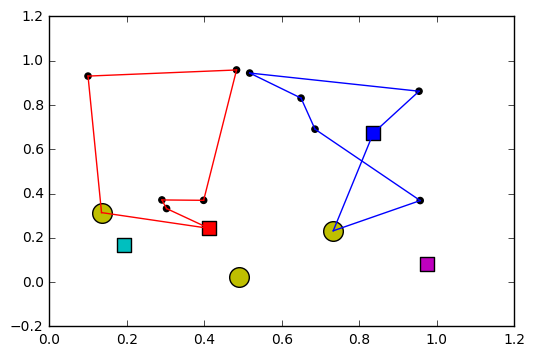

In [41]:
# Draw final solution
plt.scatter(N_p[:,0], N_p[:,1], c='k', s = quantities_v)
plt.scatter(M_p[:,0], M_p[:,1], c='y', marker = 'o', s = 200)
plt.scatter(H_p[:,0], H_p[:,1], c= colors[0:k], marker = 's', s = 100)
variables = model.getVars()
for v in variables:
    if v.varName[0] == 't' and v.x == 1.0:
        names = v.varName.split(',')
        p1 = get_entry(*str.split(names[1],'_'))
        x1 = p1[0]
        y1 = p1[1]
        p2 = get_entry(*str.split(names[2],'_'))
        x2 = p2[0]
        y2 = p2[1]
        c = colors[int(str.split(names[0],'_')[1])]
        plt.plot([x1, x2], [y1, y2], color=c, linestyle='-', linewidth=1)
plt.show()


In [42]:
import cplex
c = cplex.Cplex("mod.mps")


Selected objective sense:  MINIMIZE
Selected objective  name:  OBJ
Selected RHS        name:  RHS1
Selected bound      name:  BND1


In [43]:
alg = c.parameters.lpmethod.values

In [44]:
c.parameters.lpmethod.set(alg.auto)


In [45]:
c.solve()

CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
MIP Presolve modified 8 coefficients.
Reduced MIP has 230 rows, 549 columns, and 2780 nonzeros.
Reduced MIP has 536 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.78 ticks)
Probing time = 0.00 sec. (2.45 ticks)
Tried aggregator 1 time.
Reduced MIP has 230 rows, 549 columns, and 2780 nonzeros.
Reduced MIP has 536 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.53 ticks)
Probing time = 0.00 sec. (2.43 ticks)
Clique table members: 1742.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (1.01 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

      0     0        2.3804    22                      2.3804       29         
      0     0

('Gen:', 0, '| best fit: 94.11')
('Gen:', 1, '| best fit: 94.11')
('Gen:', 2, '| best fit: 97.38')
('Gen:', 3, '| best fit: 96.81')
('Gen:', 4, '| best fit: 96.70')
('Gen:', 5, '| best fit: 98.09')
('Gen:', 6, '| best fit: 100.43')
('Gen:', 7, '| best fit: 95.47')
('Gen:', 8, '| best fit: 93.43')
('Gen:', 9, '| best fit: 91.36')
('Gen:', 10, '| best fit: 93.25')
('Gen:', 11, '| best fit: 94.82')
('Gen:', 12, '| best fit: 96.50')
('Gen:', 13, '| best fit: 100.36')
('Gen:', 14, '| best fit: 101.30')
('Gen:', 15, '| best fit: 110.79')
('Gen:', 16, '| best fit: 116.81')
('Gen:', 17, '| best fit: 122.18')
('Gen:', 18, '| best fit: 120.41')
('Gen:', 19, '| best fit: 114.18')
('Gen:', 20, '| best fit: 110.25')
('Gen:', 21, '| best fit: 112.61')
('Gen:', 22, '| best fit: 111.90')
('Gen:', 23, '| best fit: 100.82')
('Gen:', 24, '| best fit: 96.61')
('Gen:', 25, '| best fit: 95.84')
('Gen:', 26, '| best fit: 94.79')
('Gen:', 27, '| best fit: 98.76')
('Gen:', 28, '| best fit: 95.92')
('Gen:', 29,

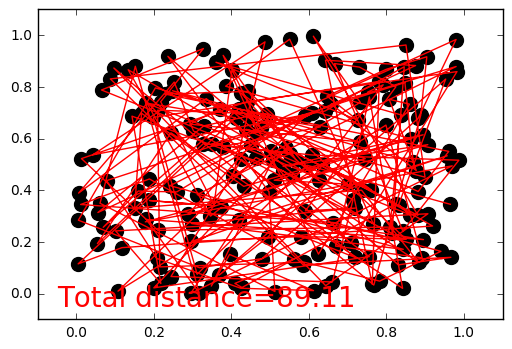

In [62]:
import matplotlib.pyplot as plt
import numpy as np

N_CITIES = 200  # DNA size
CROSS_RATE = 0.1
MUTATE_RATE = 0.02
POP_SIZE = 500
N_GENERATIONS = 500


class GA(object):
    def __init__(self, DNA_size, cross_rate, mutation_rate, pop_size, ):
        self.DNA_size = DNA_size
        self.cross_rate = cross_rate
        self.mutate_rate = mutation_rate
        self.pop_size = pop_size

        self.pop = np.vstack([np.random.permutation(DNA_size) for _ in range(pop_size)])

    def translateDNA(self, DNA, city_position):     # get cities' coord in order
        line_x = np.empty_like(DNA, dtype=np.float64)
        line_y = np.empty_like(DNA, dtype=np.float64)
        for i, d in enumerate(DNA):
            city_coord = city_position[d]
            line_x[i, :] = city_coord[:, 0]
            line_y[i, :] = city_coord[:, 1]
        return line_x, line_y

    def get_fitness(self, line_x, line_y):
        total_distance = np.empty((line_x.shape[0],), dtype=np.float64)
        for i, (xs, ys) in enumerate(zip(line_x, line_y)):
            total_distance[i] = np.sum(np.sqrt(np.square(np.diff(xs)) + np.square(np.diff(ys))))
        fitness = np.exp(self.DNA_size * 2 / total_distance)
        return fitness, total_distance

    def select(self, fitness):
        idx = np.random.choice(np.arange(self.pop_size), size=self.pop_size, replace=True, p=fitness / fitness.sum())
        return self.pop[idx]

    def crossover(self, parent, pop):
        if np.random.rand() < self.cross_rate:
            i_ = np.random.randint(0, self.pop_size, size=1)                        # select another individual from pop
            cross_points = np.random.randint(0, 2, self.DNA_size).astype(np.bool)   # choose crossover points
            keep_city = parent[~cross_points]                                       # find the city number
            swap_city = pop[i_, np.isin(pop[i_].ravel(), keep_city, invert=True)]
            parent[:] = np.concatenate((keep_city, swap_city))
        return parent

    def mutate(self, child):
        for point in range(self.DNA_size):
            if np.random.rand() < self.mutate_rate:
                swap_point = np.random.randint(0, self.DNA_size)
                swapA, swapB = child[point], child[swap_point]
                child[point], child[swap_point] = swapB, swapA
        return child

    def evolve(self, fitness):
        pop = self.select(fitness)
        pop_copy = pop.copy()
        for parent in pop:  # for every parent
            child = self.crossover(parent, pop_copy)
            child = self.mutate(child)
            parent[:] = child
        self.pop = pop


class TravelSalesPerson(object):
    def __init__(self, n_cities):
        self.city_position = np.random.rand(n_cities, 2)
        plt.ion()

    def plotting(self, lx, ly, total_d):
        plt.cla()
        plt.scatter(self.city_position[:, 0].T, self.city_position[:, 1].T, s=100, c='k')
        plt.plot(lx.T, ly.T, 'r-')
        plt.text(-0.05, -0.05, "Total distance=%.2f" % total_d, fontdict={'size': 20, 'color': 'red'})
        plt.xlim((-0.1, 1.1))
        plt.ylim((-0.1, 1.1))
        plt.pause(0.01)


ga = GA(DNA_size=N_CITIES, cross_rate=CROSS_RATE, mutation_rate=MUTATE_RATE, pop_size=POP_SIZE)

env = TravelSalesPerson(N_CITIES)
for generation in range(N_GENERATIONS):
    lx, ly = ga.translateDNA(ga.pop, env.city_position)
    fitness, total_distance = ga.get_fitness(lx, ly)
    ga.evolve(fitness)
    best_idx = np.argmax(fitness)
    print('Gen:', generation, '| best fit: %.2f' % fitness[best_idx],)

    env.plotting(lx[best_idx], ly[best_idx], total_distance[best_idx])

plt.ioff()
plt.show()